# Splitting Your Data
In this exercise, we'll load the same motor premiums data as you did in your last exercise with Python, so the first few cells should be familiar.

We'll then look at how we can split it into train/validation/test sets and how to use cross-fold validation. 

(remember, click on a cell, then control+enter will run it)

In [7]:
import pandas as pd
import numpy as np

# remember to change this path if you've saved the data somewhere else
df=pd.read_csv("MotorPremiums.csv")

In [3]:
# copy the data frame so we've still got the original in case we need it
df_cleaned = df.copy()

# choose the rows we want to keep
df_cleaned = df_cleaned[(df_cleaned.LicenceCountry=="UK") & (df_cleaned.Stored!="0")]

# this is needed so the row numbers are still in sequence
df_cleaned = df_cleaned.reset_index(drop=True)

# define the list of features to keep
selected_features = ['Age','Gender','Yrs DL','Points','NCD','Engine cc',
                     'Ins Group','Stored','Car Age','Premium']

# update the data frame
df_cleaned = df_cleaned[selected_features]

# Map 'Female' and 'Male' F and M
df_cleaned['Gender'] = df_cleaned['Gender'].replace({'Female':'F','Male':'M'})

In [8]:
# encode variables
df_cleaned = pd.get_dummies(df_cleaned, prefix_sep='_', drop_first=True)

In [5]:
# set features and targets
targetName="Premium"
featureNames=df_cleaned.columns[df_cleaned.columns != targetName]
X = df_cleaned[featureNames]
y = df_cleaned[targetName]

In [9]:
# normalise
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
X = pd.DataFrame(mm_scaler.fit_transform(X), columns=X.columns)

# Train / Test split
If you've also completed this exercise in Orange, we're now replicating what we did with Data Sampler.

This is really easy! test_size is the fraction of the data that will form your test set; random_state initialises the random number generator so if you rerun it the split will be the same (change the number for a different split).

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=402)

We have now split the data, at random, into two sets. X_train and y_train are the training data, and should contain 3499 data points. (this is a smaller number than we got with orange; in this code we've kept the data cleaning steps so there are sloghtly fewer data points to begin with)

In [14]:
X_train

,Age,Yrs DL,Points,NCD,Engine cc,Ins Group,Car Age,Gender_M,Stored_Garage,Stored_Road
2647,0.629032,0.451613,0.0,1.00,0.076923,0.500000,0.157895,0.0,1.0,0.0
887,0.709677,0.000000,0.0,0.25,0.153846,0.333333,0.052632,0.0,0.0,1.0
3043,0.032258,0.032258,0.0,1.00,0.000000,0.000000,0.000000,0.0,0.0,0.0
2388,0.725806,0.516129,0.0,0.50,0.000000,0.000000,0.736842,1.0,0.0,1.0
1503,0.370968,0.354839,0.0,0.00,0.000000,0.000000,0.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2469,0.870968,0.693548,0.0,0.00,0.000000,0.333333,0.000000,0.0,1.0,0.0
1807,0.145161,0.064516,0.0,0.50,0.076923,0.833333,0.894737,0.0,1.0,0.0
2014,0.951613,0.532258,0.0,0.75,0.000000,0.166667,0.631579,0.0,1.0,0.0
1226,0.145161,0.064516,0.0,0.00,0.153846,0.833333,0.894737,1.0,1.0,0.0


We repeat the same process to produce a validation set as well...

In [15]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

We can then use the training data to train a model and use that model for doing predictions, like this:

In [16]:
# make a new model - MLPRegressor is an artificial neural network
from sklearn.neural_network import MLPRegressor
mlp_model = MLPRegressor(hidden_layer_sizes=(10), alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, max_iter=1000, random_state=1)

# train the model on (or fit the model to) our training data
mlp_model.fit(X_train, y_train)

MLPRegressor(alpha=0.001, hidden_layer_sizes=10, learning_rate_init=0.01,
             max_iter=1000, random_state=1)

Well done, you've just made your first model in scikit learn! We can now apply this model to unseen data to make some predictions. We'll use the validation set we separated out above for this.

20.171618779616193


Text(0, 0.5, 'Predictions')

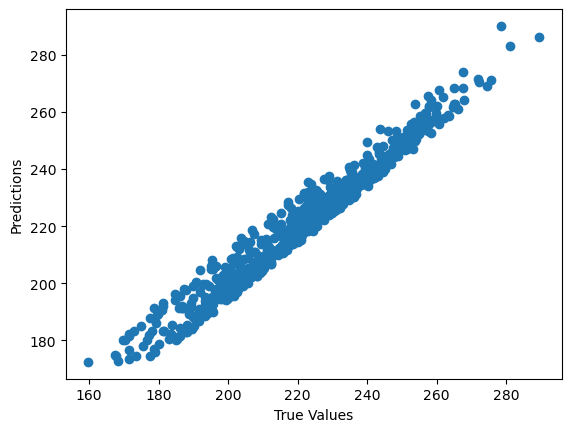

In [17]:
# make some predictions using the model
# store the predictions in y_pred
y_pred = mlp_model.predict(X_validation)

# how do the predictions compare to the true values?
# print mean square error
from sklearn import metrics
print(metrics.mean_squared_error(y_validation, y_pred))

# and a scatter plot
from matplotlib import pyplot as plt
plt.scatter(y_validation, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

# Cross-fold validation
As in Orange, sklearn makes it easy to do cross-fold validation. By default, the built-in tool for this calls the `score` function of the model to measure model quality on each fold; `score()` works differently per model but the documentation will tell you that for an `MLPRegressor` it's the R^2 value, which would be 1.0 for a perfect model. If you want to use a different measure like mean square error you can specify which one you want from the list [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

Here's how to perform the cross-fold validation, using 5 folds of our training set. We get a list of scores back in which each element is the score for one fold. We usually aggregate these (e.g. take the average) to get one overall score. You'll see the scores are negative: this is deliberate, and is so a "bigger" score (smaller error) is "better".

In [12]:
# make the train/test split again so the training data is 0.8 of the full set...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# now, compute scores for the 5 folds...
# remember, this makes 5 seperate models, and tests them each on a different 0.2 of the data set.
# the scores for these tests are returned in a list.
from sklearn.model_selection import cross_val_score

scores = cross_val_score(mlp_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(scores)
print(scores.mean())

[-19.63625695 -21.0108921  -20.79687805 -19.71271997 -18.51489647]
-19.934328707123793


We'll see later that many of the tools in sklearn use cross-fold validation internally, so you don't need to do the separate steps as above. However, it's good to know that this is what's going on behind the scenes.

You can load, train and test other models in much the same way as MLPRegressor. They all have `fit()` and `predict()` functions, and can all be supplied to cross_val_score.

Try comparing a few other model types. Browse the [documentation](https://scikit-learn.org/stable/supervised_learning.html) for regression models: don't worry specifically which you choose, as we've not given any detail on these yet, but `sklearn.linear_model.LinearRegression` and `sklearn.ensemble.RandomForestRegressor` are good places to start. Which one performs best on this data?

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

m1 = RandomForestRegressor()
m2 = LinearRegression()

scores = cross_val_score(m1, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(scores)